In [37]:
# Cell 1: Imports and setup
import os
import json
import copy
import math
import random
from typing import List, Dict, Tuple, Any
from collections import Counter, defaultdict
import re
import datetime

# Third-party imports with safe fallbacks
try:
    from datasets import load_dataset
except Exception as e:
    raise ImportError("Please install 'datasets' (pip install datasets). Error: " + str(e))

# tqdm (progress bar)
try:
    from tqdm.auto import tqdm
except:
    from tqdm import tqdm

# Optional ML / NLP libs
HAS_SENT_TRANS = False
try:
    from sentence_transformers import SentenceTransformer
    HAS_SENT_TRANS = True
except:
    HAS_SENT_TRANS = False

HAS_SKLEARN = False
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    HAS_SKLEARN = True
except:
    HAS_SKLEARN = False

# Optional plotting
try:
    import matplotlib.pyplot as plt
    HAS_PLT = True
except:
    HAS_PLT = False

# Optional networkx for dependency graph drawing
try:
    import networkx as nx
    HAS_NX = True
except:
    HAS_NX = False

# Reproducibility
RNG_SEED = 42
random.seed(RNG_SEED)

print(f"ENV: sentence-transformers={'yes' if HAS_SENT_TRANS else 'no'}, sklearn={'yes' if HAS_SKLEARN else 'no'}, matplotlib={'yes' if HAS_PLT else 'no'}, networkx={'yes' if HAS_NX else 'no'}")


ENV: sentence-transformers=no, sklearn=yes, matplotlib=yes, networkx=yes


In [38]:
!pip install torchvision 


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
!pip install matplotlib



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
!pip install seaborn tqdm


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
# Cell 2: Load VeriGUI dataset (test split is used by this dataset)
ds_dict = load_dataset("2077AIDataFoundation/VeriGUI")
# dataset provides only a 'test' split according to the original dataset description
verigui = ds_dict["test"]
print(f"Loaded VeriGUI split='test' with {len(verigui)} samples")

# Preview fields of first example
sample0 = verigui[0]
print("Sample keys:", list(sample0.keys()))
# Common keys: 'screenshot', 'elements', 'instruct', 'sub_tasks', 'result' etc.
for k in ["instruct","sub_tasks","result"]:
    if k in sample0:
        v = sample0[k]
        t = type(v)
        print(f"- {k} (type={t.__name__}) ->", (v if isinstance(v, (str, list)) and len(str(v)) < 300 else f"[{t.__name__}]"))


Loaded VeriGUI split='test' with 302 samples
Sample keys: ['folder', 'instruct', 'result', 'sub_tasks']
- instruct (type=str) -> [str]
- sub_tasks (type=list) -> [list]
- result (type=list) -> [list]


In [43]:
# Cell 3: Normalize dataset items & ensure sub_tasks is a list of dicts with keys 'instruct' and 'result'
def normalize_sample(item: Dict) -> Dict:
    """Return a normalized copy of dataset item with safe 'sub_tasks'."""
    s = dict(item)
    # Some datasets store sub_tasks as e.g., string or missing - ensure list of dicts
    st = s.get("sub_tasks", None)
    if st is None:
        s["sub_tasks"] = []
    elif isinstance(st, str):
        # fallback: split by newline if it's one string
        lines = [l.strip() for l in st.splitlines() if l.strip()]
        s["sub_tasks"] = [{"instruct": l, "result": ""} for l in lines]
    elif isinstance(st, list):
        norm = []
        for el in st:
            if isinstance(el, str):
                norm.append({"instruct": el, "result": ""})
            elif isinstance(el, dict):
                # unify keys
                instruct = el.get("instruct") or el.get("instruction") or el.get("task") or ""
                result = el.get("result", el.get("answer", ""))
                norm.append({"instruct": instruct, "result": result})
            else:
                norm.append({"instruct": str(el), "result": ""})
        s["sub_tasks"] = norm
    else:
        s["sub_tasks"] = [{"instruct": str(st), "result": ""}]
    return s

# Apply normalization and sample-check
normalized = [normalize_sample(dict(x)) for x in tqdm(verigui, desc="normalizing")]
print(f"Normalized to {len(normalized)} items, example sub_tasks count:", len(normalized[0]["sub_tasks"]))


normalizing: 100%|██████████| 302/302 [00:00<00:00, 3657.87it/s]

Normalized to 302 items, example sub_tasks count: 7


In [44]:
# Cell 4: Agent labeling heuristics
AGENT_TYPES = ["language_agent", "execution_agent", "reasoning_agent"]
AGENT_KEYWORDS = {
    "execution_agent": ["collect", "query", "search", "lookup", "look up", "fetch", "obtain", "download", "scrape", "visit", "call", "api"],
    "language_agent": ["extract", "filter", "parse", "match", "identify", "find", "format", "split", "tokenize", "regex", "text", "sentence", "line"],
    "reasoning_agent": ["determine", "decide", "compare", "verify", "which", "what is", "identify the", "choose", "rank", "reason", "infer"]
}

def heuristic_agent_label(instruction: str) -> str:
    instr = instruction.lower()
    scores = {a:0 for a in AGENT_TYPES}
    for a, kws in AGENT_KEYWORDS.items():
        for kw in kws:
            if kw in instr:
                scores[a] += 1
    # fallback: choose highest score or default to language_agent
    chosen = max(scores.items(), key=lambda x: x[1])[0]
    if all(v==0 for v in scores.values()):
        # heuristics for questions vs commands
        if instr.strip().startswith(("find","extract","get","list")):
            chosen = "execution_agent"
        elif instr.strip().startswith(("is","are","which","what","who")):
            chosen = "reasoning_agent"
        else:
            chosen = "language_agent"
    return chosen

# Annotate dataset with agent labels per subtask
for item in tqdm(normalized, desc="labeling agents"):
    for sub in item["sub_tasks"]:
        sub_instruct = sub.get("instruct","")
        sub["_agent_label"] = heuristic_agent_label(sub_instruct)

# Quick stats
counter = Counter()
for item in normalized:
    for s in item["sub_tasks"]:
        counter[s["_agent_label"]] += 1
print("Auto-labeled agent distribution:", dict(counter))


labeling agents: 100%|██████████| 302/302 [00:00<00:00, 17754.54it/s]

Auto-labeled agent distribution: {'execution_agent': 308, 'language_agent': 925, 'reasoning_agent': 67}


In [45]:
# Cell 5: Dependency extraction
# Heuristics:
# - If subtask contains "from the above", "from previous", etc -> depends on nearest earlier step
# - Otherwise compute token overlap between subtask and earlier subtasks; if overlap > threshold => dependency
TOK_RE = re.compile(r"[a-zA-Z0-9]+")

def tokens(text: str) -> List[str]:
    return TOK_RE.findall(text.lower())

def extract_dependencies_for_trajectory(subtasks: List[Dict], overlap_thresh=0.25) -> List[List[int]]:
    """
    For each subtask i, return list of indices j < i that i depends on.
    """
    deps = [[] for _ in subtasks]
    # precompute token sets
    token_sets = [set(tokens(s.get("instruct",""))) for s in subtasks]
    for i, s in enumerate(subtasks):
        instr = s.get("instruct","").lower()
        # explicit markers
        if any(kw in instr for kw in ["from the above","from above","previous","previous step","earlier","above list","above results"]):
            # link to most recent prior step
            if i-1 >= 0:
                deps[i].append(i-1)
        # token-overlap heuristic
        for j in range(0, i):
            a = token_sets[j]
            b = token_sets[i]
            if not a or not b:
                continue
            overlap = len(a & b) / max(1, len(b))
            if overlap >= overlap_thresh:
                deps[i].append(j)
        # deduplicate
        deps[i] = sorted(set(deps[i]))
    return deps

# Apply to normalized data and attach dependency lists
for item in tqdm(normalized, desc="extracting deps"):
    item["_deps"] = extract_dependencies_for_trajectory(item["sub_tasks"])

# Show example
print("Example deps for first trajectory:", normalized[0]["_deps"])


extracting deps: 100%|██████████| 302/302 [00:00<00:00, 11185.90it/s]

Example deps for first trajectory: [[], [0], [1], [], [2], [2, 4], [2]]


In [46]:
# Cell 6: Result consistency validation and normalization
def is_result_valid_for_instruction(instr: str, result: Any) -> bool:
    """
    Lightweight checks:
    - If instruction asks for list/collect -> result should be list or comma-separated string
    - If instruction asks for single 'identify' -> result should be short
    This is heuristic-only.
    """
    instr_l = instr.lower()
    if any(w in instr_l for w in ["list", "collect", "give me a list", "provide a list", "names of"]):
        if isinstance(result, list):
            return True
        if isinstance(result, str) and ("," in result or "\n" in result):
            return True
        return False
    if any(w in instr_l for w in ["identify","which","what is the","find the"]):
        # expect short answer
        if isinstance(result, (str,)) and len(result.split()) <= 20:
            return True
        if isinstance(result, list) and len(result) <= 5:
            return True
        return False
    # fallback: accept most strings
    return True

# Flag inconsistent subtasks for later manual review
issues = []
for ti, item in enumerate(normalized):
    for si, sub in enumerate(item["sub_tasks"]):
        ok = is_result_valid_for_instruction(sub.get("instruct",""), sub.get("result"))
        if not ok:
            issues.append({"traj": ti, "step": si, "instr": sub.get("instruct",""), "result": sub.get("result")})
print(f"Found {len(issues)} potentially inconsistent subtask results (heuristic).")
# Keep issues for human inspection if >0
if len(issues) > 0:
    print("Sample issues:", issues[:3])


Found 28 potentially inconsistent subtask results (heuristic).
Sample issues: [{'traj': 16, 'step': 1, 'instr': "Among SpaceX's 1st, 10th, 20th, 30th, and 40th launch missions for each year from 2022 to 2024, find the single mission with the highest number of satellites carried, and record the mission code and quantity.", 'result': ['the highest number of satellites carried: Year: 2023, Mission time: 1st, Number: 114, Mission code: transporter6', 'Year: 2022, Mission time: 1st, Number: 49, Mission code: sl-4-5', 'Year: 2022, Mission time: 10th, Number: 48, Mission code: sl-4-15', 'Year: 2022, Mission time: 20th, Number: 53, Mission code: sl-3-1', 'Year: 2022, Mission time: 30th, Number: 46, Mission code: sl-3-1', 'Year: 2022, Mission time: 40th, Number: 46, Mission code: sl-3-4', 'Year: 2023, Mission time: 1st, Number: 114, Mission code: transporter6', 'Year: 2023, Mission time: 10th, Number: 55, Mission code: sl-5-4', 'Year: 2023, Mission time: 20th, Number: 56, Mission code: sl5-5', 

In [47]:
# Cell 7: Negative examples augmentation
NEG_OPTIONS = ["incorrect_agent", "out_of_order", "missing_dependency"]

def generate_negative_examples(item: Dict, n_per_item=1) -> List[Dict]:
    """
    Given a normalized trajectory item, produce n_per_item negative variants.
    """
    negs = []
    subtasks = copy.deepcopy(item["sub_tasks"])
    deps = copy.deepcopy(item["_deps"])
    for k in range(n_per_item):
        variant = copy.deepcopy(item)
        v_subtasks = copy.deepcopy(subtasks)
        v_deps = copy.deepcopy(deps)
        choice = random.choice(NEG_OPTIONS)
        if choice == "incorrect_agent":
            # flip agent for one random subtask to an incorrect one
            idx = random.randrange(len(v_subtasks))
            orig = v_subtasks[idx].get("_agent_label")
            alternatives = [a for a in AGENT_TYPES if a != orig]
            v_subtasks[idx]["_agent_label"] = random.choice(alternatives)
        elif choice == "out_of_order" and len(v_subtasks) >= 2:
            # swap two neighboring subtasks (simulate order violation)
            i = random.randrange(len(v_subtasks)-1)
            v_subtasks[i], v_subtasks[i+1] = v_subtasks[i+1], v_subtasks[i]
            # recompute deps conservatively
            v_deps = extract_dependencies_for_trajectory(v_subtasks)
        elif choice == "missing_dependency" and len(v_subtasks) >= 1:
            i = random.randrange(len(v_subtasks))
            v_deps[i] = []  # drop dependencies (simulate broken execution)
        else:
            # fallback: incorrect_agent
            idx = random.randrange(len(v_subtasks))
            v_subtasks[idx]["_agent_label"] = random.choice([a for a in AGENT_TYPES if a != v_subtasks[idx].get("_agent_label")])
        variant["sub_tasks"] = v_subtasks
        variant["_deps"] = v_deps
        variant["_neg_type"] = choice
        negs.append(variant)
    return negs

# Create a small set of negatives and attach to dataset as _negatives for later mixing
NEG_PER_ITEM = 0  # default 0 for full dataset (set >0 to generate negatives inline)
if NEG_PER_ITEM > 0:
    for item in normalized:
        item["_negatives"] = generate_negative_examples(item, n_per_item=NEG_PER_ITEM)
print("Negative example generation configured. NEG_PER_ITEM =", NEG_PER_ITEM)


Negative example generation configured. NEG_PER_ITEM = 0


In [48]:
try:
    from sentence_transformers import SentenceTransformer
    HAS_SENT_TRANS = True
except ImportError:
    HAS_SENT_TRANS = False

In [49]:
# Cell 8: Embedding utilities (prefer sentence-transformers; fallback to TF-IDF)
EMBEDDING_DIM = 384  # default for many sentence-transformers

# Utility to safely convert any text/list to lowercase string
def safe_text(doc):
    if isinstance(doc, list):
        doc = " ".join([str(d) for d in doc])
    elif doc is None:
        doc = ""
    return str(doc).lower()

if HAS_SENT_TRANS:
    sbert = SentenceTransformer("all-mpnet-base-v2")  # if available locally
    def embed_fn(texts: list):
        texts = [safe_text(t) for t in texts]
        return sbert.encode(texts, show_progress_bar=False)
    EMBEDDING_DIM = sbert.get_sentence_embedding_dimension()
    print("Using SentenceTransformer, dim=", EMBEDDING_DIM)

elif HAS_SKLEARN:
    # TF-IDF fallback - will produce sparse vectors; we project to dense via mean pooling
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    corpus = []
    for item in normalized:
        corpus.append(safe_text(item.get("instruct","")))
        for s in item["sub_tasks"]:
            corpus.append(safe_text(s.get("instruct","")))
    tfidf_matrix = tfidf.fit_transform(corpus)

    def embed_fn(texts: list):
        texts = [safe_text(t) for t in texts]
        X = tfidf.transform(texts).toarray()
        norms = (X**2).sum(axis=1, keepdims=True)**0.5 + 1e-12
        return (X / norms).astype(float)

    EMBEDDING_DIM = tfidf.transform(["test"]).shape[1]
    print("Using TF-IDF fallback, dim=", EMBEDDING_DIM)

else:
    # Very small fallback: bag-of-characters hashing embedding
    def simple_hash_embed(texts: list, dim=128):
        out = []
        for t in texts:
            t = safe_text(t)
            vec = [0.0]*dim
            for i,ch in enumerate(t):
                vec[ord(ch) % dim] += 1.0
            s = sum([x*x for x in vec])**0.5 + 1e-12
            out.append([x/s for x in vec])
        return out

    embed_fn = lambda texts: simple_hash_embed(texts, dim=128)
    EMBEDDING_DIM = 128
    print("Using simple hashing fallback, dim=", EMBEDDING_DIM)


Using TF-IDF fallback, dim= 5000


In [50]:
# Cell 9: Build a fixed-length state vector for each step
import numpy as np

def build_state_vector(traj: Dict, step_idx: int, max_history=10) -> np.ndarray:
    """
    Return a 1D numpy state vector representing:
      - embedding(main instruction)  -> EMBED_MAIN
      - embedding(current subtask)   -> EMBED_CUR
      - aggregated embedding(prev results up to max_history) -> EMBED_PREV (mean)
      - dependency binary vector for this step w.r.t. previous steps up to max_history -> DEP_VEC
      - agent history counts one-hot style (counts of each agent used in previous steps) -> AG_HIST
      - progress: steps_done/total -> scalar
    """
    main_text = traj.get("instruct","")
    cur_text = traj["sub_tasks"][step_idx].get("instruct","")
    prev_texts = []
    for i in range(max(0, step_idx-max_history), step_idx):
        prev_texts.append(traj["sub_tasks"][i].get("result","") or traj["sub_tasks"][i].get("instruct",""))
    # embeddings
    e_main = np.array(embed_fn([main_text]))[0].astype(np.float32)
    e_cur = np.array(embed_fn([cur_text]))[0].astype(np.float32)
    if prev_texts:
        e_prev = np.mean(np.array(embed_fn(prev_texts)), axis=0).astype(np.float32)
    else:
        e_prev = np.zeros_like(e_main, dtype=np.float32)
    # deps vector: which of most recent max_history steps are cited
    deps = traj.get("_deps", [])
    cur_deps = deps[step_idx] if step_idx < len(deps) else []
    dep_vec = np.zeros((max_history,), dtype=np.float32)
    for d in cur_deps:
        rel_idx = step_idx - d - 1  # 0 means immediate previous
        if 0 <= rel_idx < max_history:
            dep_vec[rel_idx] = 1.0
    # agent history counts
    agent_hist = np.zeros((len(AGENT_TYPES),), dtype=np.float32)
    for i in range(max(0, step_idx-max_history), step_idx):
        agent = traj["sub_tasks"][i].get("_agent_label")
        if agent in AGENT_TYPES:
            idx = AGENT_TYPES.index(agent)
            agent_hist[idx] += 1.0
    # normalize agent history
    if agent_hist.sum() > 0:
        agent_hist = agent_hist / (agent_hist.sum())
    # progress
    progress = np.array([step_idx / max(1, len(traj["sub_tasks"]))], dtype=np.float32)
    # concatenate: [e_main, e_cur, e_prev, dep_vec, agent_hist, progress]
    state = np.concatenate([
        e_main, e_cur, e_prev,
        dep_vec.astype(np.float32),
        agent_hist.astype(np.float32),
        progress.astype(np.float32)
    ])
    return state

# Quick dimension check
sv = build_state_vector(normalized[0], 0)
print("State vector dim:", sv.shape)


State vector dim: (15014,)


In [51]:
sv

array([0., 0., 0., ..., 0., 0., 0.], shape=(15014,), dtype=float32)

In [52]:
sample = normalized[0]
sample


{'folder': '675',
 'instruct': 'Find the Italian film that won the Grand Prix du Jury at the 1989 Cannes Film Festival, and was written and directed by Giuseppe Tornatore. For this film, please provide the following information: the name of the actor who played the blind projectionist Alfredo and won the BAFTA Award for Best Actor for this role; a famous quote about "life" spoken by this actor in the film; the specific award jointly received by the film\'s composer and his son; the duration of the film\'s longest version; the film\'s initial release date in Italy; the name of the designer who won the César Award for Best Poster; and the film\'s box office gross in the United States and Canada.',
 'result': ["film's title:Cinema Paradiso",
  "the actor's name:Philippe Noiret",
  'line spoken:Life isn’t like in the movies. Life… is much harder',
  'the names of the composer and his son:Ennio Morricone,Andrea Morricone,specific award:BAFTA Award for For Best Original Film Music',
  'durat

In [53]:
# Cell 10: PyTorch Dataset that yields episodes suitable for on-policy RL (one trajectory -> one episode)
import torch
from torch.utils.data import Dataset, DataLoader

class CoordinatorEpisodeDataset(Dataset):
    """
    Each sample is a trajectory (episode). We return:
      - list of state vectors (T x D)
      - list of ground-truth agent actions (T,)  -> agent indices
      - list of dependency masks, raw subtasks, etc (metadata)
    """
    def __init__(self, trajectories: List[Dict], embed_fn_local=None, max_history=10):
        self.trajs = trajectories
        self.max_history = max_history
        self.embed_fn = embed_fn_local or embed_fn

    def __len__(self):
        return len(self.trajs)

    def __getitem__(self, idx):
        traj = self.trajs[idx]
        T = len(traj["sub_tasks"])
        states = []
        agent_targets = []
        for t in range(T):
            st = build_state_vector(traj, t, max_history=self.max_history)
            states.append(st.astype(np.float32))
            agent_label = traj["sub_tasks"][t].get("_agent_label", "language_agent")
            agent_targets.append(AGENT_TYPES.index(agent_label))
        states = np.stack(states, axis=0)  # T x D
        agent_targets = np.array(agent_targets, dtype=np.int64)
        return {
            "states": torch.tensor(states),
            "agent_targets": torch.tensor(agent_targets),
            "traj_id": idx,
            "raw": traj
        }

def collate_episodes(batch):
    # pad episodes to the max length in batch
    max_T = max(b["states"].shape[0] for b in batch)
    D = batch[0]["states"].shape[1]
    states = torch.zeros((len(batch), max_T, D), dtype=torch.float32)
    masks = torch.zeros((len(batch), max_T), dtype=torch.bool)
    agent_targets = -torch.ones((len(batch), max_T), dtype=torch.long)
    raws = []
    for i, b in enumerate(batch):
        T = b["states"].shape[0]
        states[i, :T, :] = b["states"]
        masks[i, :T] = 1
        agent_targets[i, :T] = b["agent_targets"]
        raws.append(b["raw"])
    return {"states": states, "masks": masks, "agent_targets": agent_targets, "raws": raws}

# Example dataset and DataLoader
ep_dataset = CoordinatorEpisodeDataset(normalized[:50])  # small sample for test
ep_loader = DataLoader(ep_dataset, batch_size=8, collate_fn=collate_episodes)
batch = next(iter(ep_loader))
print("Batch states shape:", batch["states"].shape, "masks:", batch["masks"].shape, "targets:", batch["agent_targets"].shape)


Batch states shape: torch.Size([8, 7, 15014]) masks: torch.Size([8, 7]) targets: torch.Size([8, 7])


In [58]:
# Cell 11: Reward computation with frequency-based weighting

# Approximate agent frequencies (from dataset stats)
AGENT_COUNTS = {
    "execution_agent": 308,
    "language_agent": 925,
    "reasoning_agent": 67
}

# Compute weights inversely proportional to counts (normalize to ~20 for common scale)
total_counts = sum(AGENT_COUNTS.values())
AGENT_WEIGHTS = {k: total_counts / v for k, v in AGENT_COUNTS.items()}

# Define correct-step reward and incorrect penalty per agent type
AGENT_STEP_REWARD = {k: round(w, 1) for k, w in AGENT_WEIGHTS.items()}  # higher for rare agents
AGENT_INCORRECT_PENALTY = {k: -round(w/2, 1) for k, w in AGENT_WEIGHTS.items()}  # softer penalty, still scaled

print("Agent step rewards:", AGENT_STEP_REWARD)
print("Agent incorrect penalties:", AGENT_INCORRECT_PENALTY)

def compute_step_reward(traj: Dict, step_idx: int, action_agent_idx: int, reward_type="shaped"):
    """
    Reward heuristics:
     + weighted positive if predicted agent == ground-truth agent
     + weighted penalty if predicted agent is incorrect
    """
    true_agent_name = traj["sub_tasks"][step_idx].get("_agent_label")
    true_agent = AGENT_TYPES.index(true_agent_name)
    chosen_agent_name = AGENT_TYPES[action_agent_idx]

    reward = 0.0
    if action_agent_idx == true_agent:
        reward += AGENT_STEP_REWARD.get(true_agent_name, 20.0)
    else:
        reward += AGENT_INCORRECT_PENALTY.get(chosen_agent_name, -10.0)

    # dependency check (offline simulation)
    deps = traj.get("_deps", [])
    cur_deps = deps[step_idx] if step_idx < len(deps) else []

    return reward

def compute_terminal_reward(traj: Dict, executed_steps: List[int], final_result_matches: bool):
    # large reward if final result matches, penalty otherwise
    return 100.0 if final_result_matches else -50.0


Agent step rewards: {'execution_agent': 4.2, 'language_agent': 1.4, 'reasoning_agent': 19.4}
Agent incorrect penalties: {'execution_agent': -2.1, 'language_agent': -0.7, 'reasoning_agent': -9.7}


In [ ]:
# # Cell 11: Reward computation (dense shaped + terminal)
# def compute_step_reward(traj: Dict, step_idx: int, action_agent_idx: int, reward_type="shaped"):
#     """
#     Reward heuristics:
#      + large positive if predicted agent == ground-truth agent
#      + small positive if dependency respected (i.e., all declared deps already executed)
#      - penalty for incorrect agent
#      - penalty for executing before deps
#     """
#     true_agent = AGENT_TYPES.index(traj["sub_tasks"][step_idx].get("_agent_label"))
#     reward = 0.0
#     if action_agent_idx == true_agent:
#         reward += 20.0
#     else:
#         reward -= 10.0
#     # dependency check (offline: assume all deps executed)
#     return reward

# def compute_terminal_reward(traj: Dict, executed_steps: List[int], final_result_matches: bool):
#     if final_result_matches:
#         return 100.0
#     else:
#         return -50.0

# # --- Demo / Output for this cell ---
# sample = normalized[0]  # pick first trajectory
# print("Sample trajectory subtasks:", [s["instruct"] for s in sample["sub_tasks"]])
# print("Ground-truth agent labels:", [s["_agent_label"] for s in sample["sub_tasks"]])

# # simulate actions: choose correct agent for all steps
# simulated_actions = [AGENT_TYPES.index(s["_agent_label"]) for s in sample["sub_tasks"]]
# step_rewards = [compute_step_reward(sample, i, a) for i,a in enumerate(simulated_actions)]
# terminal_reward = compute_terminal_reward(sample, executed_steps=list(range(len(simulated_actions))), final_result_matches=True)

# print("Step-wise rewards:", step_rewards)
# print("Terminal reward:", terminal_reward)
# print("Total cumulative reward:", sum(step_rewards) + terminal_reward)


Sample trajectory subtasks: ["Collect a list of films that won the Grand Prix du Jury at the 1989 Cannes Film Festival, recording each film's title, director, screenwriter, and country of production.", 'From the above list, filter out films written and directed by Giuseppe Tornatore, and whose country of production is Italy, to identify the target film.', 'Look up the cast and crew of the target film, identify the name of the actor who played "Alfredo", and consult the BAFTA Award records for "Best Actor" in the corresponding year to obtain the actor\'s name.', 'Search the target film\'s script, subtitle files, or authoritative movie quote databases to extract a line spoken by the character "Alfredo" that contains a theme about "life".', "Obtain the names of the target film's composer and his son, and search major film award databases (such as the David di Donatello Awards, BAFTA Awards, etc.) to find the specific award they jointly received for the film.", 'Query movie databases (such

In [59]:
# Cell 12: Minimal environment for coordinator orchestration (episodic over sub_tasks)
class CoordinatorEnv:
    """
    Simple gym-like env:
      - state: state vector for current step
      - action: discrete agent selection (0..len(AGENT_TYPES)-1) (could be extended to multi-action)
      - step() returns (next_state, reward, done, info)
    NOTE: This environment simulates agent execution by using ground-truth 'result' and marks step as succeeded if agent matches ground truth.
    """
    def __init__(self, traj: Dict, max_history=10):
        self.traj = traj
        self.T = len(traj["sub_tasks"])
        self.max_history = max_history
        self.current = 0
        self.executed = set()
        self.done = False
        self.state_dim = build_state_vector(traj, 0, max_history=self.max_history).shape[0]

    def reset(self):
        self.current = 0
        self.executed = set()
        self.done = False
        return build_state_vector(self.traj, 0, max_history=self.max_history)

    def step(self, action_agent_idx: int):
        if self.done:
            raise RuntimeError("Step called on done environment")
        # compute reward
        r = compute_step_reward(self.traj, self.current, action_agent_idx)
        # mark executed
        self.executed.add(self.current)
        info = {"expected_agent_idx": AGENT_TYPES.index(self.traj["sub_tasks"][self.current].get("_agent_label"))}
        self.current += 1
        if self.current >= self.T:
            self.done = True
            # terminal reward (naive): final result compare - here assume True for successful demo
            r += compute_terminal_reward(self.traj, list(self.executed), final_result_matches=True)
            return None, r, True, info
        else:
            next_state = build_state_vector(self.traj, self.current, max_history=self.max_history)
            return next_state, r, False, info

# Quick environment smoke test
env = CoordinatorEnv(normalized[0])
s0 = env.reset()
s1, r, done, info = env.step(AGENT_TYPES.index(normalized[0]["sub_tasks"][0].get("_agent_label")))
print("Step reward:", r, "done:", done, "info:", info)


Step reward: 4.2 done: False info: {'expected_agent_idx': 1}


Dataset stats: {
  "num_trajs": 302,
  "avg_subtasks": 4.304635761589404,
  "agent_counts": {
    "execution_agent": 308,
    "language_agent": 925,
    "reasoning_agent": 67
  },
  "avg_deps_per_traj": 5.69205298013245
}


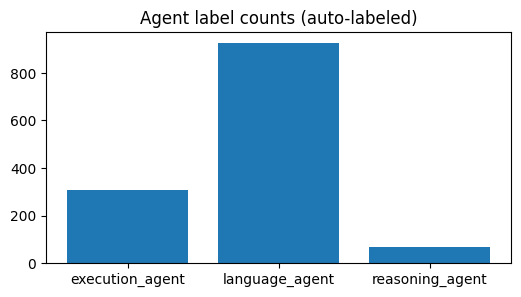

In [60]:
# Cell 13: Dataset statistics and simple visualizations
def dataset_stats(trajs: List[Dict]) -> Dict[str, Any]:
    stats = {}
    stats['num_trajs'] = len(trajs)
    stats['avg_subtasks'] = sum(len(t['sub_tasks']) for t in trajs)/max(1,len(trajs))
    agent_counts = Counter()
    dep_counts = []
    for t in trajs:
        for s in t['sub_tasks']:
            agent_counts[s.get("_agent_label")] += 1
        dep_counts.append(sum(len(d) for d in t.get("_deps", [])))
    stats['agent_counts'] = dict(agent_counts)
    stats['avg_deps_per_traj'] = sum(dep_counts)/max(1,len(dep_counts))
    return stats

stats = dataset_stats(normalized)
print("Dataset stats:", json.dumps(stats, indent=2))

# plotting (if available)
if HAS_PLT:
    labels = list(stats['agent_counts'].keys())
    vals = list(stats['agent_counts'].values())
    plt.figure(figsize=(6,3))
    plt.bar(labels, vals)
    plt.title("Agent label counts (auto-labeled)")
    plt.show()
else:
    print("Matplotlib not available: skipping plots.")


In [62]:
# Cell 14: Train/Val/Test split and create CoordinatorEpisodeDataset for each split
# Using manual split to avoid sklearn dependency

def create_splits(trajectories: list, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=RNG_SEED):
    """Split trajectories into train/val/test sets manually."""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    n = len(trajectories)
    indices = list(range(n))
    random.Random(seed).shuffle(indices)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    train_idx = indices[:n_train]
    val_idx = indices[n_train:n_train+n_val]
    test_idx = indices[n_train+n_val:]
    return [trajectories[i] for i in train_idx], [trajectories[i] for i in val_idx], [trajectories[i] for i in test_idx]

# Apply splits
train_trajs, val_trajs, test_trajs = create_splits(normalized, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)
print("Split sizes:", len(train_trajs), len(val_trajs), len(test_trajs))

# Create episode datasets
train_ep_ds = CoordinatorEpisodeDataset(train_trajs)
val_ep_ds = CoordinatorEpisodeDataset(val_trajs)
test_ep_ds = CoordinatorEpisodeDataset(test_trajs)
print("Episode datasets created.")

# Optional: quick sanity check
print("Example trajectory subtasks (train):", [len(t["sub_tasks"]) for t in train_trajs[:3]])


Split sizes: 211 45 46
Episode datasets created.
Example trajectory subtasks (train): [4, 2, 7]


In [63]:
# Cell 15: Save everything required for training
OUT_DIR = "./preprocessed_verigui_new"
os.makedirs(OUT_DIR, exist_ok=True)

# Save normalized trajectories (including _agent_label, _deps)
with open(os.path.join(OUT_DIR, "trajectories_normalized.json"), "w", encoding="utf-8") as f:
    json.dump(normalized, f, ensure_ascii=False, indent=2)

# Save splits indices and summary
summary = {
    "generated_at": datetime.datetime.utcnow().isoformat(),
    "n_total": len(normalized),
    "n_train": len(train_trajs),
    "n_val": len(val_trajs),
    "n_test": len(test_trajs),
    "agent_types": AGENT_TYPES
}
with open(os.path.join(OUT_DIR, "summary.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)

# Save a small example torch dataset for episodes if user wants
import torch
torch.save({"train": train_trajs, "val": val_trajs, "test": test_trajs}, os.path.join(OUT_DIR, "trajs_split.pt"))
print(f"Saved preprocessed artifacts to {OUT_DIR}")


Saved preprocessed artifacts to ./preprocessed_verigui_new


C:\Users\hala\AppData\Local\Temp\ipykernel_13676\609745762.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.datetime.utcnow().isoformat(),


TRAJ ID: 0
Instruction: Find the Italian film that won the Grand Prix du Jury at the 1989 Cannes Film Festival, and was written and directed by Giuseppe Tornatore. For this film, please provide the following information: the name of the actor who played the blind projectionist Alfredo and won the BAFTA Award for Best Actor
 Step 0: agent_label=execution_agent, instruct=Collect a list of films that won the Grand Prix du Jury at the 1989 Cannes Film Festival, recording each film's title, director, screenwriter, and country of production.
   deps -> []
 Step 1: agent_label=language_agent, instruct=From the above list, filter out films written and directed by Giuseppe Tornatore, and whose country of production is Italy, to identify the target film.
   deps -> [0]
 Step 2: agent_label=execution_agent, instruct=Look up the cast and crew of the target film, identify the name of the actor who played "Alfredo", and consult the BAFTA Award records for "Best Actor" in the corresponding year to ob

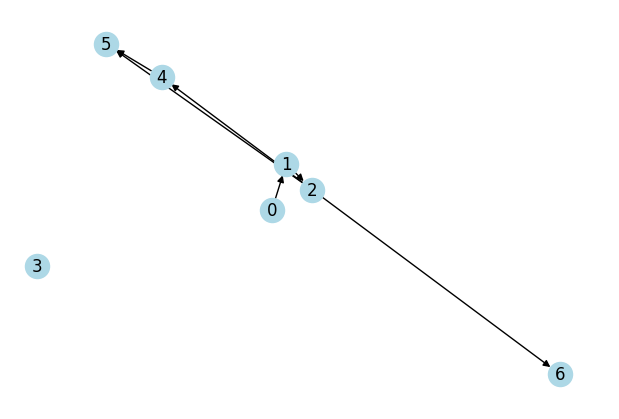


NEXT STEPS:
 1) (Optional) Manually review & correct a small subset of auto-labeled subtask agent labels.
 2) Implement or plug a PPO agent (e.g., stable-baselines3) that consumes CoordinatorEnv.
 3) Use train_ep_ds -> sample episodes -> run on-policy PPO updates.
 4) Track metrics: agent selection accuracy, dependency violation rate, final task success.
If you want, I can now:
 A) generate a full PPO training script using stable-baselines3 (if available),
 B) produce a Colab-ready notebook with pip installs for missing libs,
 C) run a small supervised behavior-cloning training loop for warm-start.


In [64]:
# Cell 16: Debugging helper & next steps
def show_traj_debug(traj: Dict, idx: int = 0):
    print("TRAJ ID:", idx)
    print("Instruction:", traj.get("instruct","")[:300])
    for i, s in enumerate(traj["sub_tasks"]):
        print(f" Step {i}: agent_label={s.get('_agent_label')}, instruct={s.get('instruct')[:200]}")
        print("   deps ->", traj.get("_deps",[[]])[i] if i < len(traj.get("_deps",[[]])) else [])
    if HAS_NX:
        G = nx.DiGraph()
        for i in range(len(traj["sub_tasks"])):
            G.add_node(i, label=str(i))
        for i,dlist in enumerate(traj.get("_deps",[])):
            for d in dlist:
                G.add_edge(d, i)
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6,4))
        nx.draw(G, with_labels=True, node_color="lightblue", arrows=True)
        plt.show()
    else:
        print("NetworkX not available. Skipping graph draw.")

# Show debug for a sample trajectory
show_traj_debug(normalized[0], idx=0)

# Next steps (short checklist)
print("\nNEXT STEPS:")
print(" 1) (Optional) Manually review & correct a small subset of auto-labeled subtask agent labels.")
print(" 2) Implement or plug a PPO agent (e.g., stable-baselines3) that consumes CoordinatorEnv.")
print(" 3) Use train_ep_ds -> sample episodes -> run on-policy PPO updates.")
print(" 4) Track metrics: agent selection accuracy, dependency violation rate, final task success.")
print("If you want, I can now:")
print(" A) generate a full PPO training script using stable-baselines3 (if available),")
print(" B) produce a Colab-ready notebook with pip installs for missing libs,")
print(" C) run a small supervised behavior-cloning training loop for warm-start.")


In [65]:
data = torch.load("./preprocessed_verigui_new/trajs_split.pt")
print(list(data["train"][0].keys()))


['folder', 'instruct', 'result', 'sub_tasks', '_deps']


In [66]:
print(data["train"][0]["sub_tasks"][0].keys())


dict_keys(['instruct', 'result', '_agent_label'])


In [67]:
import pprint
pprint.pprint(data["train"][0])


{'_deps': [[], [], [], [0, 2]],
 'folder': 'V4_51',
 'instruct': 'Search the resumes of newly appointed experts in the 2023 IEEE '
             'Fellow Computer Society and find those with the highest Google '
             'Scholar h-index. List (1) name, (2) highest h-index, (3) title '
             'of the most papers published in a single year in the past three '
             'years, and (4) corresponding journals.',
 'result': ['Name:Mark N. Billinghurst',
            'Highest h-index:103',
            ' Title of the most papers published in a single year in the past '
            'three years:2023',
            'Corresponding journals:Journal of Management in Engineering'],
 'sub_tasks': [{'_agent_label': 'language_agent',
                'instruct': 'Collect the list of new IEEE Fellow Computer '
                            'Society members and their resume information in '
                            '2023 (first ten in order).',
                'result': ['Name:Gail-Joon Ahn,Re

In [71]:
import torch
data = torch.load("./preprocessed_verigui_new/trajs_split.pt")
print(data["train"][0])


{'folder': 'V4_51', 'instruct': 'Search the resumes of newly appointed experts in the 2023 IEEE Fellow Computer Society and find those with the highest Google Scholar h-index. List (1) name, (2) highest h-index, (3) title of the most papers published in a single year in the past three years, and (4) corresponding journals.', 'result': ['Name:Mark N. Billinghurst', 'Highest h-index:103', ' Title of the most papers published in a single year in the past three years:2023', 'Corresponding journals:Journal of Management in Engineering'], 'sub_tasks': [{'instruct': 'Collect the list of new IEEE Fellow Computer Society members and their resume information in 2023 (first ten in order).', 'result': ['Name:Gail-Joon Ahn,Resume:Prof. Ahn is Founding Director of Laboratory of Security Engineering for Future Computing (SEFCOM) and Center for Cybersecurity and Trusted Foundations (CTF). His principal research and teaching interests are in information and systems security. His research foci include s